<a href="https://colab.research.google.com/github/Nicordaro/Project_MLDL/blob/master/Project_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Politecnico di Torino**

**01TXFSM - Machine learning and Deep learning**

**Incremental Learning in Image Classification**

**Cordaro Nicolò - s272145**

**Di Nepi Marco - sMATRICOLA**

**Falletta Alberto - s277971**


In [1]:
# !pip3 install 'torch==1.4.0'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

     |████████████████████████████████| 753.4MB 22kB/s 
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
     |████████████████████████████████| 4.0MB 6.9MB/s 
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 634kB 6.1MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110385 sha256=08b1f59cccc6f8bd23ec436540468ed0e971059940e25c61473ed95cf3c50a77
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181e1c12ed1e8655dcd583b8
Successfully built Pillow-SIMD


**Imports**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import resnet18

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from google.colab import drive

**Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

# Init at 10 because first train is on 10 classes
NUM_CLASSES = 10

# Used for the pseudorandom shuffle of the split
SEED = 42

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Pre-processing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # https://github.com/pytorch/examples/blob/master/imagenet/main.py
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))                                 
])

**Prepare Dataset**

CIFAR100 has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another.

Each of the downloaded files is a Python "pickled" object produced with cPickle.

In [0]:
from torchvision.datasets import CIFAR100

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

DATA_DIR = './CIFAR100'

if not os.path.isdir('./CIFAR100'):
  dataset = CIFAR100(DATA_DIR, train=True, transform=None, target_transform=None, download=True)

train = unpickle(os.path.join(DATA_DIR, "cifar-100-python", "train"))
test = unpickle(os.path.join(DATA_DIR, "cifar-100-python", "test"))
train, test

data -- a 50000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

labels -- a list of 50000 numbers in the range 0-99. The number at index i indicates the label of the ith image in the array data.

In [0]:
print(f"train is now a dictionary with keys: ", train.keys(), "\n")
print(f"Number of items in train set: ", len(train[b'data']), "\n")

print(f"Data -> list of {len(train[b'data'])} lists of {len(train[b'data'][0])} integers RGB:")
print(train[b'data'], "\n")

print(f"Labels -> list of {len(train[b'fine_labels'])} integers 0-99:")
print(train[b'fine_labels'], "\n")


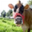

In [7]:
from PIL import Image
import numpy as np

def from_list_to_PIL_image(img_list):
  """
  Questa funzione prende una lista di 3072 integers
  e ritorna la Pil image 32x32
  """
  img_data = []
  for i in range(0, 1024):
    RGB_tuple = [img_list[i], img_list[i+1024], img_list[i+1024+1024]]
    img_data.append(tuple(RGB_tuple))
    pil_image = Image.new('RGB', (32, 32))
    pil_image.putdata(img_data)
    # image_out.save("image_name.png") 
  return pil_image
  
example = from_list_to_PIL_image(train[b'data'][0])
display(example)

In [0]:
# Runna in 1 ORAAAA  :(

train_dataset = []
test_dataset = []

for i in range(0, len(train[b'data'])):
  train_dataset.append((from_list_to_PIL_image(train[b'data'][i]), train[b'fine_labels'][i]))
  print(f"{i+1} of {len(train[b'data'])}")

for i in range(0, len(test[b'data'])):
  test_dataset.append((from_list_to_PIL_image(test[b'data'][i]), test[b'fine_labels'][i]))
  print(f"{i+1} of {len(train[b'data'])}")

1 of 50000
2 of 50000
3 of 50000
4 of 50000
5 of 50000
6 of 50000
7 of 50000
8 of 50000
9 of 50000
10 of 50000
11 of 50000
12 of 50000
13 of 50000
14 of 50000
15 of 50000
16 of 50000
17 of 50000
18 of 50000
19 of 50000
20 of 50000
21 of 50000
22 of 50000
23 of 50000
24 of 50000
25 of 50000
26 of 50000
27 of 50000
28 of 50000
29 of 50000
30 of 50000
31 of 50000
32 of 50000
33 of 50000
34 of 50000
35 of 50000
36 of 50000
37 of 50000
38 of 50000
39 of 50000
40 of 50000
41 of 50000
42 of 50000
43 of 50000
44 of 50000
45 of 50000
46 of 50000
47 of 50000
48 of 50000
49 of 50000
50 of 50000
51 of 50000
52 of 50000
53 of 50000
54 of 50000
55 of 50000
56 of 50000
57 of 50000
58 of 50000
59 of 50000
60 of 50000
61 of 50000
62 of 50000
63 of 50000
64 of 50000
65 of 50000
66 of 50000
67 of 50000
68 of 50000
69 of 50000
70 of 50000
71 of 50000
72 of 50000
73 of 50000
74 of 50000
75 of 50000
76 of 50000
77 of 50000
78 of 50000
79 of 50000
80 of 50000
81 of 50000
82 of 50000
83 of 50000
84 of 50000
8

KeyboardInterrupt: ignored

**Dataloaders**

In [0]:
source_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

**Prepare Network**

In [0]:
net = resnet18(pretrained=False)
net.fc = nn.Linear(512, NUM_CLASSES)

**Prepare Training**

In [0]:
# Loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Parameters to optimize:
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
parameters_to_optimize = net.parameters()

# Optimizers
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Scheduler
# A scheduler dynamically changes learning rate
# The most common scheduler is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)